<a href="https://colab.research.google.com/github/JuanDa14Sa/Travelling-Salesman-Problem/blob/main/TSP_Genetics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np
import timeit

def point_circle(center_x,center_y,radius):
    theta = 2*math.pi*random.random() #Entre 0 y 2pi

    r=radius*math.sqrt(random.random())

    x = r * math.cos(theta) + center_x
    y = r * math.sin(theta) + center_y
    return x,y

def gen_points(num_points,center_x=0,center_y=0,radius=1):
    points=[]
    for i in range(num_points):
        x,y=point_circle(center_x,center_y,radius)
        points.append((x,y))
    return points

def dist(p1,p2):
    return math.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)

def matrix(points): 
    matrix_dist=[[dist(points[i],points[j])for j in range(len(points))] for i in range(len(points))]
    return matrix_dist

def route_len(R,matrix_dist_): 
    sum=0
    for i in range(len(R)-1):
        sum=sum+matrix_dist_[R[i]][R[i+1]]
    sum=sum+matrix_dist_[R[-1]][R[1]]
    return sum

def gen_route(num_points): 
    route=np.random.choice(range(num_points),replace=False,size=num_points)
    return route

def gen_population(num_points,num_pop):
    return [gen_route(num_points) for _ in range(num_pop)]

def fitness_indiv(indiv,matrix_dist): #Minimizar la distancia es maximizar el fitness
    return 1/route_len(indiv,matrix_dist)

def fitness(population,matrix_dist):
    return [fitness_indiv(indiv,matrix_dist) for indiv in population]

def selection(fitness_pop,population): #Roulette selection method (Probabilidades basadas en el fitness)
    sum=np.sum(fitness_pop)
    prob_selection=fitness_pop/sum
    selected_indices = np.random.choice(range(len(population)),size=len(population),p=prob_selection)
    return np.take(population,selected_indices,axis=0)

def crossover_indiv(parent1,parent2,prob_cross):
    if np.random.rand()<prob_cross:    
        cross_point=random.randint(0,len(parent1))
        child1, child2 = parent1.copy(),parent2.copy()
        for i in range(cross_point):
            value1,value2= child1[i],child2[i]   
            child1[np.where(child1==value2)[0]],child2[np.where(child2==value1)[0]]=value1,value2
            child1[i],child2[i]= value2,value1
        return child1,child2
    else:
        return parent1,parent2

def crossover(population,prob_cross):
    childs=[]
    num_pop=len(population)
    for i in range(0,num_pop,2):
        child1,child2=crossover_indiv(population[np.random.randint(0,num_pop)],population[np.random.randint(0,num_pop)],prob_cross)
        childs.append(child1)
        childs.append(child2)
    return np.array(childs)

def mutation(indiv,prob_mutate,population,fitness_pop):  #Elitismo
    if np.random.rand()<prob_mutate:
        indiv_=indiv.copy()
        tmp=np.random.choice(len(indiv),replace=False,size=2)
        i=tmp[0]
        j=tmp[1]
        indiv_[i],indiv_[j]=indiv_[j],indiv_[i]
        return indiv_
    else:
        indiv_,_=currentBest(fitness_pop,population)
        return indiv_

def mutate(fitness_pop,population,prob_mutate):
    return [mutation(indiv,prob_mutate,population,fitness_pop) for indiv in population]

def currentBest(fitness_pop,population): 
    index=np.argmax(fitness_pop)
    return population[index],fitness_pop[index]

def TSP_gen(points,matrix_dist,num_pop,num_generations,prob_cross=0.8,prob_mutate=0.4):
    fitnesss=[]
    routes=[]
    population=gen_population(len(points),num_pop)
    fitness_pop=fitness(population,matrix_dist)
    current_best_indiv,current_best_score=currentBest(fitness_pop,population)
    final_best_indiv,final_best_score=current_best_indiv,current_best_score
    for _ in range(num_generations):
        population=selection(fitness_pop,population)

        population=crossover(population,prob_cross)

        fitness_pop=fitness(population,matrix_dist)

        population=mutate(fitness_pop,population,prob_mutate)

        fitness_pop=fitness(population,matrix_dist)
        
        current_best_indiv,current_best_score=currentBest(fitness_pop,population)
        fitnesss.append(current_best_score)
        routes.append(current_best_indiv)
        if current_best_score>final_best_score:
            final_best_indiv,final_best_score=current_best_indiv,current_best_score
    return final_best_indiv,final_best_score,fitnesss,routes

In [13]:
num_points=200
points=gen_points(num_points)
matrix_dist=matrix(points)
num_pop=100
num_generations=100

best_route,best_score,fitnesss,routes=TSP_gen(points,matrix_dist,num_pop,num_generations)

Text(0, 0.5, 'Función de fitness')

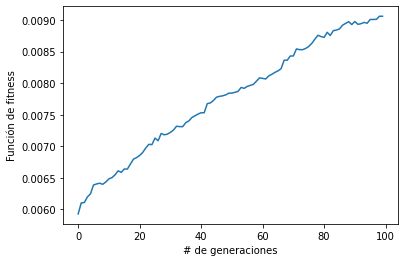

In [14]:
plt.plot(range(num_generations),fitnesss)
plt.xlabel('# de generaciones')
plt.ylabel('Función de fitness')

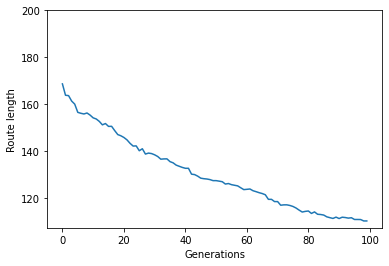

In [15]:

lengths=[route_len(r,matrix_dist) for r in routes]

def plot_length(num_iterations,data):
    plt.plot(range(num_iterations),data)
    plt.ylabel('Route length')
    plt.xlabel('Generations')
    plt.ylim(top=num_points)
plot_length(num_generations,lengths)

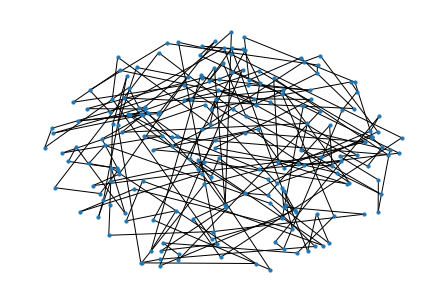

In [16]:
import networkx as nx

def plot_graph(points,route,node_size=10,width=1):
    G = nx.Graph()
    num_points=len(points)
    for i in range(num_points):
        G.add_node(i,pos=points[i])
        if i==num_points-1:
            G.add_edge(route[i],route[0])
        else:
            G.add_edge(route[i],route[i+1])

    nx.draw(G,nx.get_node_attributes(G, 'pos'),node_size=node_size,width=width)
plot_graph(points,best_route)

In [17]:
n_=[100,200,500,1000,1500,2000,3000,4000,5000,10000]

num_pop=50
num_generations=50

times=[]
lengths_=[]
for num_point_ in n_:
    points_=gen_points(num_point_)
    matrix_dist_=matrix(points_)
    start=timeit.default_timer()
    best_route,_,_,_=TSP_gen(points_,matrix_dist_,num_pop,num_generations)
    end=timeit.default_timer()
    times.append(end-start)
    lengths_.append(route_len(best_route,matrix_dist_))

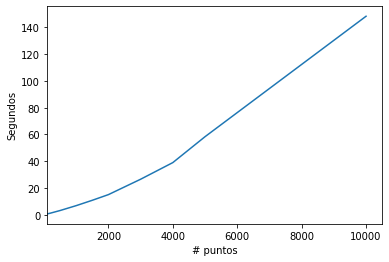

In [18]:
plt.plot(n_,times)
plt.xlim(left=100)
plt.ylabel('Segundos')
plt.xlabel('# puntos');

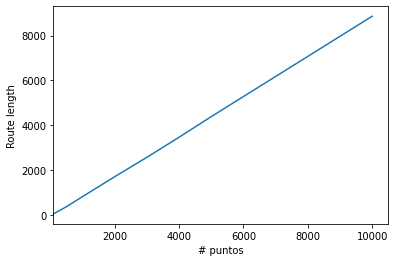

In [19]:
plt.plot(n_,lengths_)
plt.xlim(left=100)
plt.xlabel('# puntos')
plt.ylabel('Route length');